In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import torch
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, plot_single_system
from data.metrics import maximum_mean_discrepancy, wasserstein_distance
from models.diffusion import *

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
lta, lta_osda = 'LTA', 'OSDA-free'
fau, fau_osda = 'FAU', 'OSDA-free'
gis, gis_osda = 'GIS', 'OSDA-free'

In [3]:
model_type = 'diff'
fname = 'v3'
split = 'system'

# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

model, configs = load_model(model_type, fname, split)
syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset = get_prediction_and_ground_truths(model, configs, cond_scale=0.75, split='train')

Loading model and configs...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


In [4]:
syn_pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.5,0.000000,3.686546,150.0,6.00000,CHA,Cn1ccnc1
1,10.000000,1.717997,99.0,250.0,0.544060,0.000000,0.585431,0.0,10.000000,0.500000,125.0,89.21486,GME,OSDA-free
2,30.000000,1.717997,99.0,250.0,0.024777,0.000000,0.400000,0.0,15.151515,0.333333,100.0,168.00000,BEA,CC[N+](CC)(CC)CC
3,6.493506,1.717997,99.0,250.0,0.000000,0.000000,0.628926,0.0,27.247800,0.764456,200.0,168.00000,Dense/Amorphous,CC[N+](CC)(CC)CC
4,78.270430,1.717997,99.0,250.0,0.632418,0.000000,0.016817,0.0,19.426657,0.028325,170.0,48.00000,MFI,CCCC[N+](CC)(CC)CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368720,0.300000,1.000000,99.0,250.0,0.000000,0.000000,0.000000,0.0,9.607612,0.435744,170.0,120.00000,FAU,CCC[N+](CCC)(CCC)CCC
368721,30.000000,1.717997,99.0,250.0,1.290861,0.000000,0.191491,0.0,40.000000,0.112338,170.0,72.00000,MFI,CCC[N+](CCC)(CCC)CCC
368722,34.967620,1.717997,99.0,250.0,0.334140,0.000000,0.233819,0.0,10.000000,0.000000,160.0,168.00000,NES,OSDA-free
368723,400.000000,0.000000,99.0,250.0,0.000000,0.168481,0.000000,0.5,3.500000,0.496783,175.0,336.00000,BEA,C[N+]1(C)CC2C3C=CC(CC3)C2C1


LTA OSDA-free


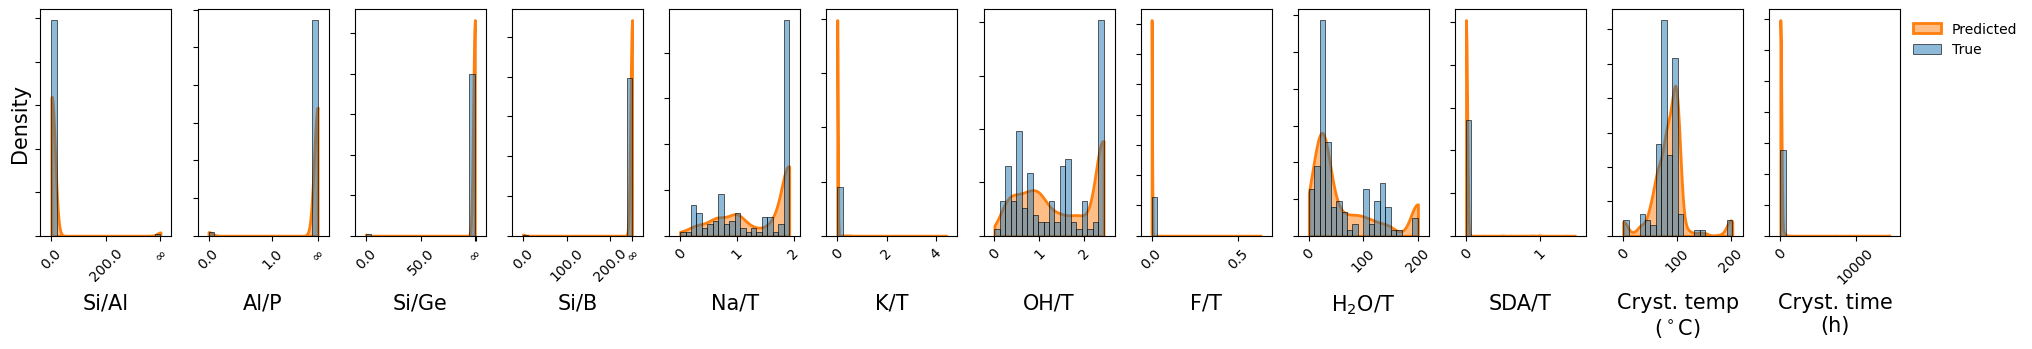

FAU OSDA-free


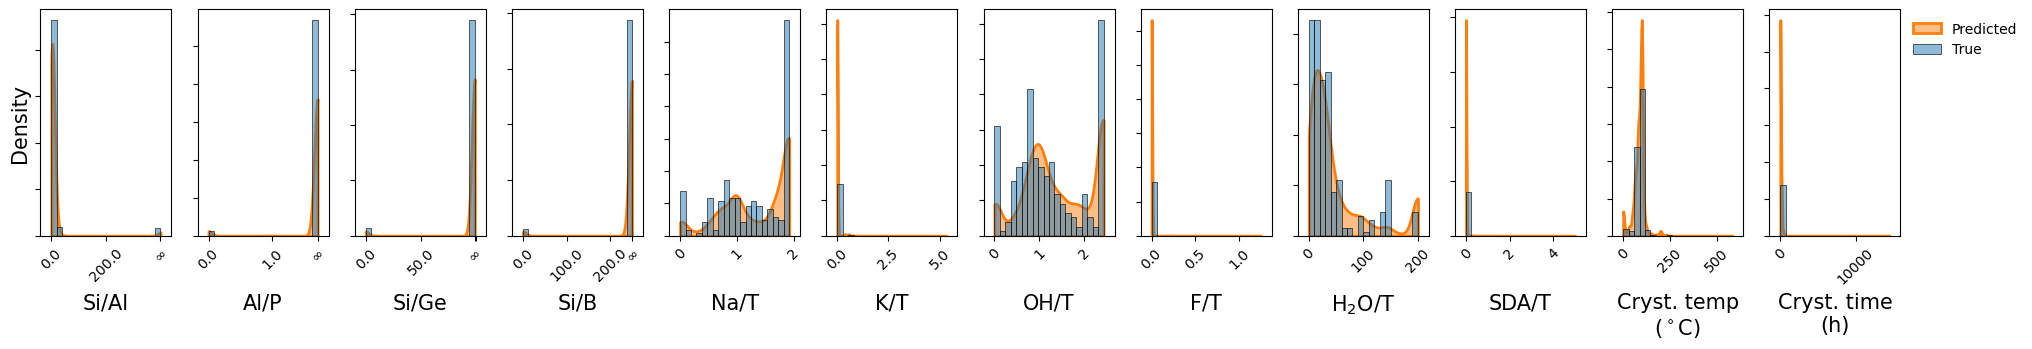

GIS OSDA-free


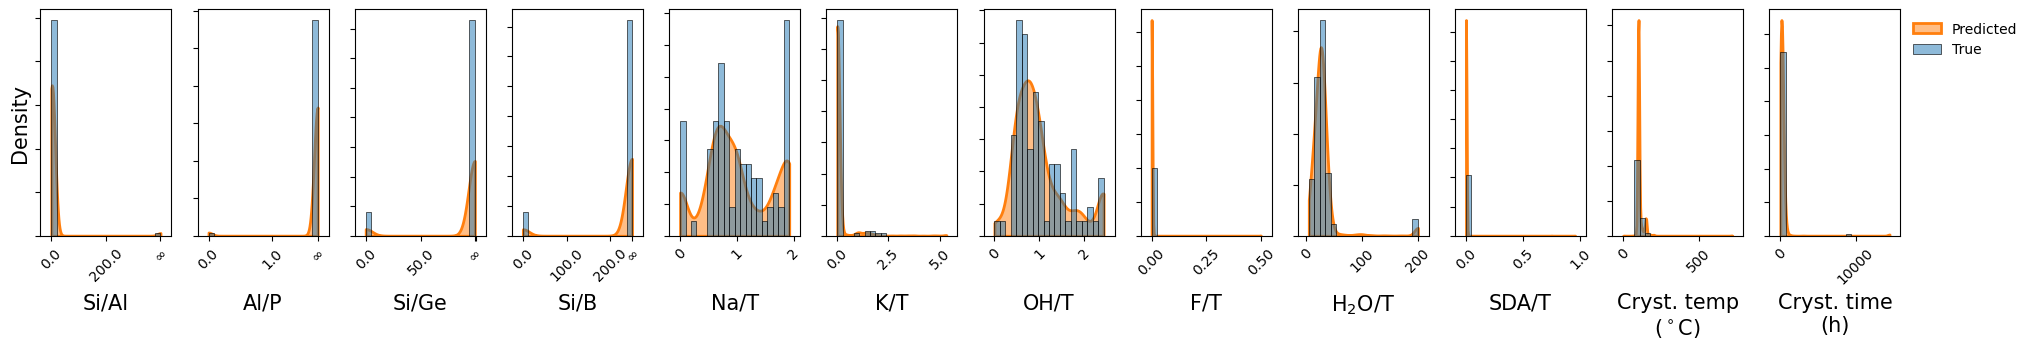

In [5]:
plot_single_system(syn_pred, syn_true, zeo=lta, osda=lta_osda)
plot_single_system(syn_pred, syn_true, zeo=fau, osda=fau_osda)
plot_single_system(syn_pred, syn_true, zeo=gis, osda=gis_osda)

In [6]:
lta_pred, lta_true = syn_pred[(syn_pred['zeo'] == lta) & (syn_pred['osda'] == lta_osda)], syn_true[(syn_true['zeo'] == lta) & (syn_true['osda'] == lta_osda)]
fau_pred, fau_true = syn_pred[(syn_pred['zeo'] == fau) & (syn_pred['osda'] == fau_osda)], syn_true[(syn_true['zeo'] == fau) & (syn_true['osda'] == fau_osda)]
gis_pred, gis_true = syn_pred[(syn_pred['zeo'] == gis) & (syn_pred['osda'] == gis_osda)], syn_true[(syn_true['zeo'] == gis) & (syn_true['osda'] == gis_osda)]

In [7]:
# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    lta_true[f'{het}/Si'] = 1. / lta_true[f'Si/{het}']
    lta_true[f'{het}/Si'] = lta_true[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    lta_true[f'{het}'] = lta_true[f'{het}/Si']
    lta_true['Si'] = [1.]*len(lta_true)

    lta_pred[f'{het}/Si'] = 1. / lta_pred[f'Si/{het}']
    lta_pred[f'{het}/Si'] = lta_pred[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    lta_pred[f'{het}'] = lta_pred[f'{het}/Si']
    lta_pred['Si'] = [1.]*len(lta_pred)

tot_hets = lta_true[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    lta_true[f'{c}'] = lta_true[f'{c}/T'] * tot_hets
    lta_true[f'{c}'] = lta_true[f'{c}'].map(lambda x: 1e-4 if x == 0. else x)
    lta_pred[f'{c}'] = lta_pred[f'{c}/T'] * tot_hets
    lta_pred[f'{c}'] = lta_pred[f'{c}'].map(lambda x: 1e-4 if x == 0. else x)

/tmp/ipykernel_2579759/1979109862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lta_true[f'{het}/Si'] = 1. / lta_true[f'Si/{het}']
/tmp/ipykernel_2579759/1979109862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lta_true[f'{het}/Si'] = lta_true[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
/tmp/ipykernel_2579759/1979109862.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [8]:
# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    fau_true[f'{het}/Si'] = 1. / fau_true[f'Si/{het}']
    fau_true[f'{het}/Si'] = fau_true[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    fau_true[f'{het}'] = fau_true[f'{het}/Si']
    fau_true['Si'] = [1.]*len(fau_true)

    fau_pred[f'{het}/Si'] = 1. / fau_pred[f'Si/{het}']
    fau_pred[f'{het}/Si'] = fau_pred[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    fau_pred[f'{het}'] = fau_pred[f'{het}/Si']
    fau_pred['Si'] = [1.]*len(fau_pred)

tot_hets = fau_true[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    fau_true[f'{c}'] = fau_true[f'{c}/T'] * tot_hets
    fau_true[f'{c}'] = fau_true[f'{c}'].map(lambda x: 1e-4 if x == 0. else x)
    fau_pred[f'{c}'] = fau_pred[f'{c}/T'] * tot_hets
    fau_pred[f'{c}'] = fau_pred[f'{c}'].map(lambda x: 1e-4 if x == 0. else x)

/tmp/ipykernel_2579759/1823632046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fau_true[f'{het}/Si'] = 1. / fau_true[f'Si/{het}']
/tmp/ipykernel_2579759/1823632046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fau_true[f'{het}/Si'] = fau_true[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
/tmp/ipykernel_2579759/1823632046.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [9]:
# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    gis_true[f'{het}/Si'] = 1. / gis_true[f'Si/{het}']
    gis_true[f'{het}/Si'] = gis_true[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    gis_true[f'{het}'] = gis_true[f'{het}/Si']
    gis_true['Si'] = [1.]*len(gis_true)

    gis_pred[f'{het}/Si'] = 1. / gis_pred[f'Si/{het}']
    gis_pred[f'{het}/Si'] = gis_pred[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    gis_pred[f'{het}'] = gis_pred[f'{het}/Si']
    gis_pred['Si'] = [1.]*len(gis_pred)

tot_hets = gis_true[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    gis_true[f'{c}'] = gis_true[f'{c}/T'] * tot_hets
    gis_true[f'{c}'] = gis_true[f'{c}'].map(lambda x: 1e-4 if x == 0. else x)
    gis_pred[f'{c}'] = gis_pred[f'{c}/T'] * tot_hets
    gis_pred[f'{c}'] = gis_pred[f'{c}'].map(lambda x: 1e-4 if x == 0. else x)

/tmp/ipykernel_2579759/2939722463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gis_true[f'{het}/Si'] = 1. / gis_true[f'Si/{het}']
/tmp/ipykernel_2579759/2939722463.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gis_true[f'{het}/Si'] = gis_true[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
/tmp/ipykernel_2579759/2939722463.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_true[col] = _df_true[col] / norm
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:812: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pred[col] = _df_pred[col] / norm


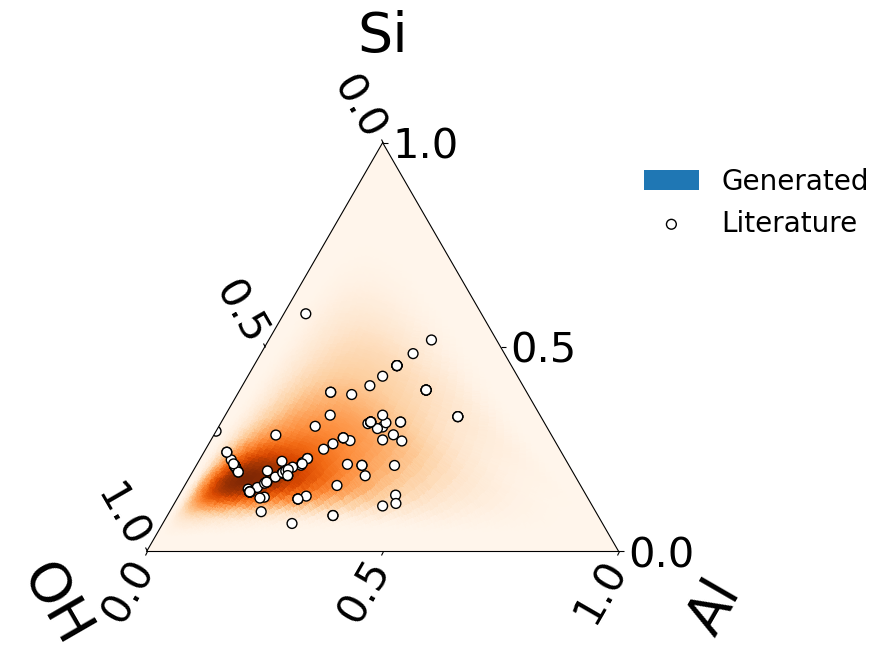

In [10]:
utils.plot_ternary(lta_true, lta_pred, ['Si', 'OH', 'Al'], n_bins=400, grid_border_frac=3, cmap='Oranges', markersize=50)

/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_true[col] = _df_true[col] / norm
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:812: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pred[col] = _df_pred[col] / norm


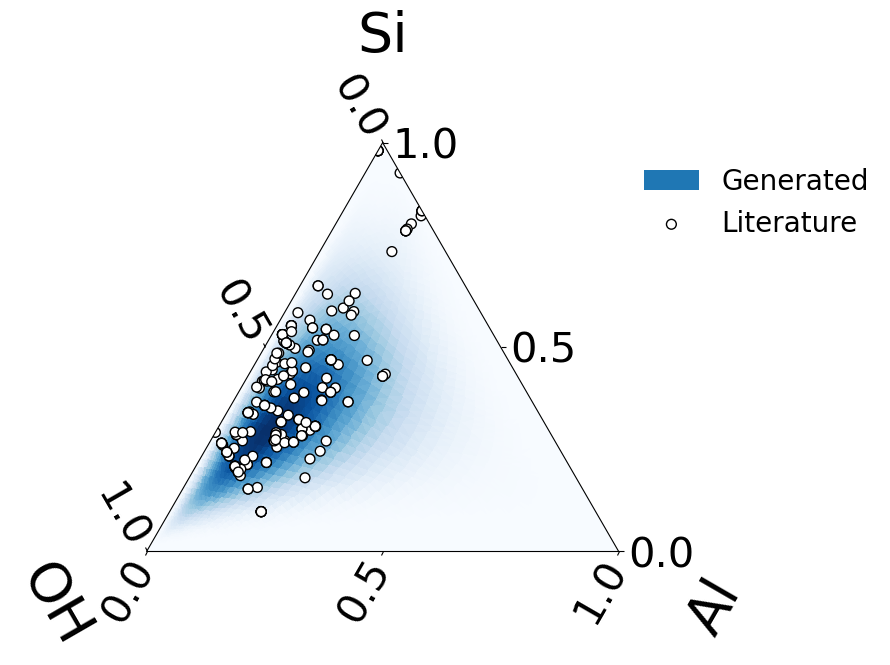

In [11]:
utils.plot_ternary(fau_true, fau_pred, ['Si', 'OH', 'Al'], n_bins=400, grid_border_frac=3, cmap='Blues', markersize=50)

/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_true[col] = _df_true[col] / norm
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:812: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pred[col] = _df_pred[col] / norm


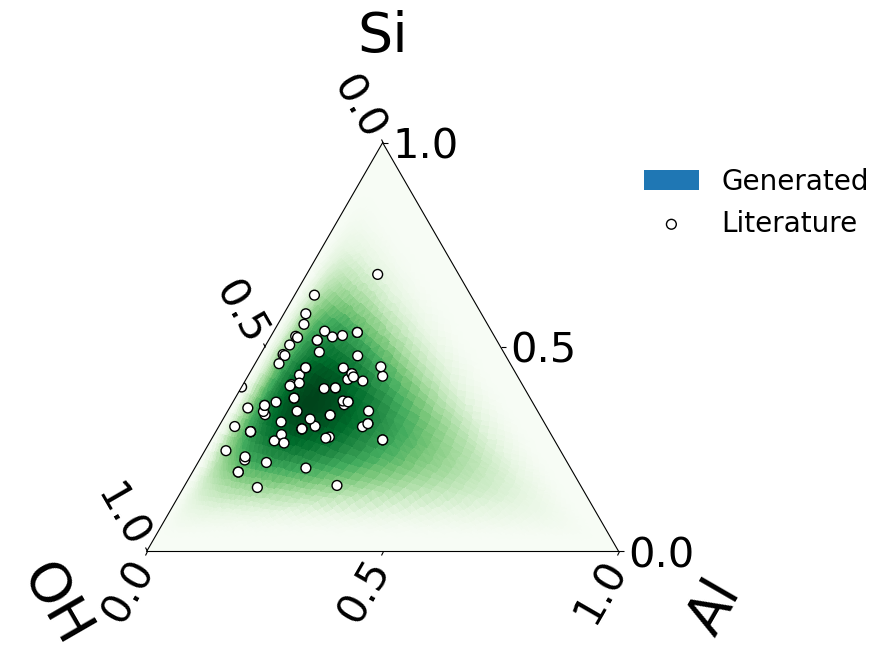

In [12]:
utils.plot_ternary(gis_true, gis_pred, ['Si', 'OH', 'Al'], n_bins=400, grid_border_frac=3, cmap='Greens', markersize=50)

/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_true[col] = _df_true[col] / norm
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:869: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pred[col] = _df_pred[col] / norm


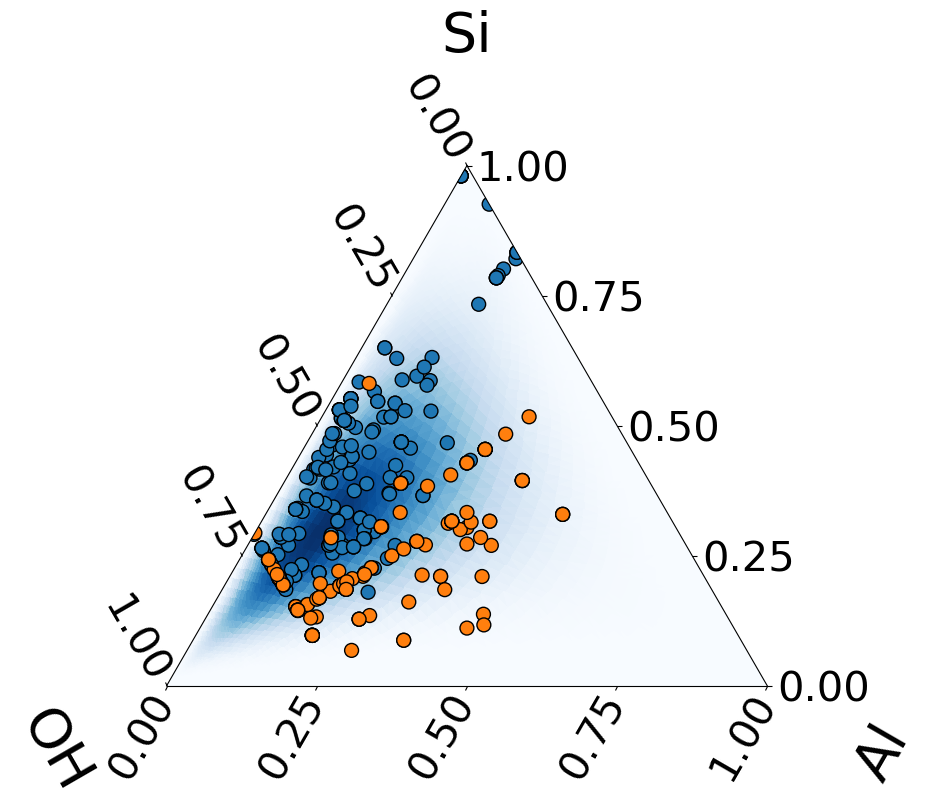

In [13]:
utils.plot_ternary_multiple([fau_true, lta_true], [fau_pred, lta_pred], ['Si', 'OH', 'Al'], ['FAU', 'LTA'], n_bins=400, grid_border_frac=3, cmaps=['Blues', 'Oranges'], cmap_alphas=[1., 0.], markersize=100, markeralphas=[1., 1.], markercolors=['tab:blue', 'tab:orange'], legend=False)

/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_true[col] = _df_true[col] / norm
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:869: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_pred[col] = _df_pred[col] / norm


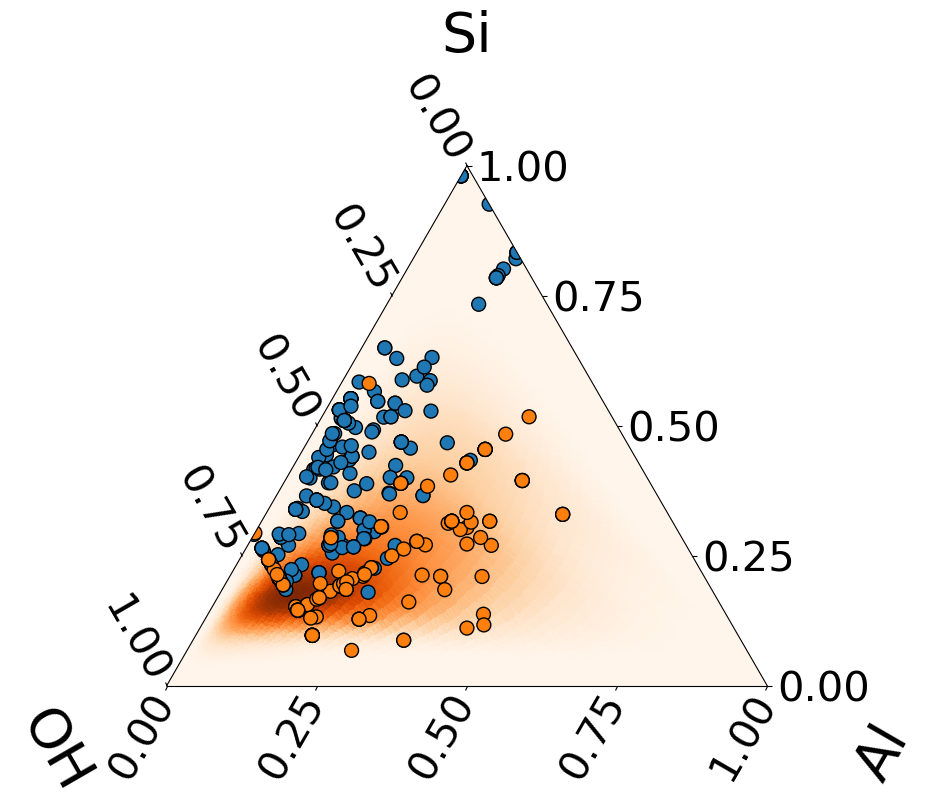

In [14]:
utils.plot_ternary_multiple([fau_true, lta_true], [fau_pred, lta_pred], ['Si', 'OH', 'Al'], ['FAU', 'LTA'], n_bins=400, grid_border_frac=3, cmaps=['Blues', 'Oranges'], cmap_alphas=[0., 1.], markersize=100, markeralphas=[1., 1.], markercolors=['tab:blue', 'tab:orange'], legend=False)